The goal of this colab is to determine whether we need to include explicit hydrogens in reaction operators and whether RDKit handles them correctly.  The answer is yes and yes -- both the RO and substrate need explicit hydrogens

In [ ]:
# Install and import RDKit
%%capture
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import rdChemReactions


# RO Projection with only implicit hydrogens

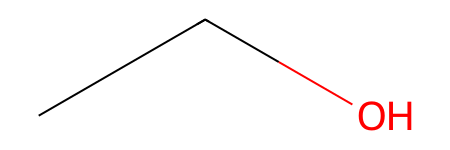

In [ ]:
# Import a test substrate from SMILES with implicit hydrogens
ethanol = Chem.MolFromSmiles('CCO')
ethanol

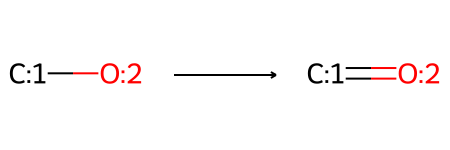

In [ ]:
# Define a SMIRKS string for oxidation of an alcohol with no H's specifified
smirks = '[C:1]-[O:2]>>[C:1]=[O:2]'
# Create a reaction operator object from the SMIRKS string
ro = rdChemReactions.ReactionFromSmarts(smirks)
ro


CC=O


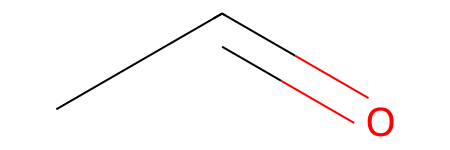

In [ ]:
# Apply the ro to ethanol (no H's)
products = ro.RunReactants([ethanol])

# Loop through the products and print SMILES strings
pdt = None
for product_set in products:
    for mol in product_set:
        print(Chem.MolToSmiles(mol))
        pdt = mol
pdt

So, applying an implicit-hydrogen operator to an implicit-hydrogen alcohol substrate results in the correct product.

However, that RO incorrectly handles this substrate:

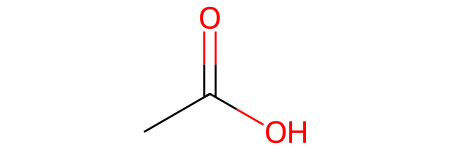

In [ ]:
ethanoic = Chem.MolFromSmiles('CC(=O)O')
ethanoic

CC(=O)=O


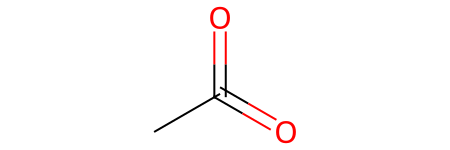

In [ ]:
# Apply the ro to ethanoic acid (no H's)
products = ro.RunReactants([ethanoic])

# Loop through the products and print SMILES strings
pdt = None
for product_set in products:
    for mol in product_set:
        print(Chem.MolToSmiles(mol))
        pdt = mol
pdt


It got this wrong.  There should be no products.  By not including the Hydrogens in the reaction operator, you get an overly broad prediction that does not consider their necessity in the reaction resulting in an answer that violates valency -- there are 5 atoms attached to the carbon here.


# RO Projection with explicit hydrogen RO on implicit hydrogen substrate

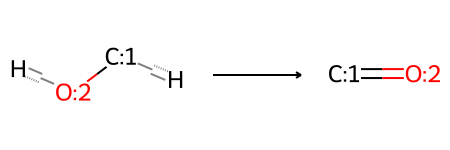

In [ ]:
# Define a SMIRKS string for oxidation of an alcohol with no H's specifified
smirksWithHs = '[C:1]([H])-[O:2]([H])>>[C:1]=[O:2]'
# Create a reaction operator object from the SMIRKS string
roWithHs = rdChemReactions.ReactionFromSmarts(smirksWithHs)
roWithHs

In [ ]:
# Apply the ro to ethanol (no H's)
products = roWithHs.RunReactants([ethanol])

# Loop through the products and print SMILES strings
pdt = None
for product_set in products:
    for mol in product_set:
        print(Chem.MolToSmiles(mol))
        pdt = mol
pdt


It incorrectly predicts no product.  There should be a product.

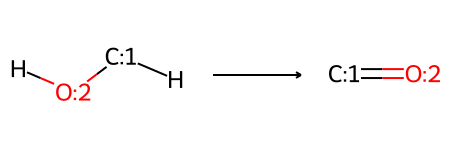

In [ ]:
# Define a SMIRKS string for oxidation of an alcohol with no H's specifified
# In this version we explicitly state the single bonds
smirksWithHsSingleBonds = '[C:1](-[H])-[O:2](-[H])>>[C:1]=[O:2]'
# Create a reaction operator object from the SMIRKS string
roWithWithHsSingleBonds = rdChemReactions.ReactionFromSmarts(smirksWithHsSingleBonds)
roWithWithHsSingleBonds

In [ ]:
# Apply the ro to ethanol (no H's)
products = roWithWithHsSingleBonds.RunReactants([ethanol])

# Loop through the products and print SMILES strings
pdt = None
for product_set in products:
    for mol in product_set:
        print(Chem.MolToSmiles(mol))
        pdt = mol
pdt


It got this wrong too.  It appears that it does not match the hydrogens in the RO to implicit hydrogens.

# RO Projection with explicit hydrogens

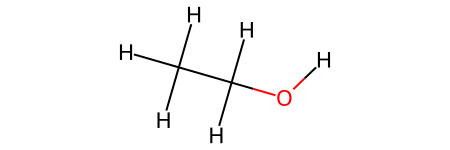

In [ ]:
explicitEthanol = Chem.AddHs(ethanol)
explicitEthanol


[H]C(=O)C([H])([H])[H]
[H]C(=O)C([H])([H])[H]


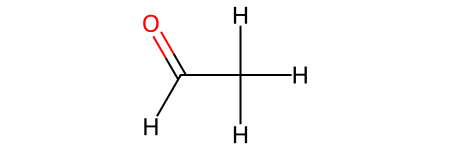

In [ ]:
# Apply the explicit hydrogen ro to ethanol with explicit hydrogens
products = roWithHs.RunReactants([explicitEthanol])

# Loop through the products and print SMILES strings
pdt = None
for product_set in products:
    for mol in product_set:
        print(Chem.MolToSmiles(mol))
        pdt = mol
pdt


It gets the right answer. There are two products (that are identical) because there are 2 hydrogens on the carbon and thus the RO could apply to either of them.

[H]C(=O)C([H])([H])[H]
[H]C(=O)C([H])([H])[H]


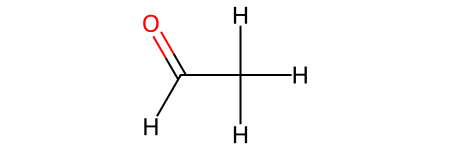

In [ ]:
# Apply the ro to ethanol with explicit H's
products = roWithWithHsSingleBonds.RunReactants([explicitEthanol])

# Loop through the products and print SMILES strings
pdt = None
for product_set in products:
    for mol in product_set:
        print(Chem.MolToSmiles(mol))
        pdt = mol
pdt


It works equally well with the bonds explicitly stated as single bonds

# Conclusions
RDKit works just fine with hydrogens as long as both the RO and substrate have explicit H's.  It the substrate is implicit and the SMIRKS has a hydrogen, it won't match and there will be no product.  If both are implicit, RDKit will give a product, but it may be an erroneous product with chemically invalid valency.